# MIEX
is a Mie scattering code for large grains by [Wolf & Voshchinnikov (2004)](https://ui.adsabs.harvard.edu/abs/2004CoPhC.162..113W).

In [17]:
# import packages and define functions
import miex.miex as miex
import numpy as np
import matplotlib.pyplot as plt

# converter for lambda/n/k database files
def conv(line):
    return line.replace("D", "e")

Define wavelength and refractive index:

In [18]:
# define refractive index (real, imag) and wavelength [micron] as numpy array
ri_real = np.array([1.5])
ri_imag = np.array([0.0])
wavelength = np.array([1.0])

# OR use a dust data file (three columns: wavelength/micron real imag)
filename = "ri-data/silicate"
wavelength, ri_real, ri_imag = np.loadtxt(filename, unpack=True, comments="#", converters=conv)

nlam = len(wavelength)

Define dust grain size:

In [19]:
# define single grain size [micron]
radmin = 1.0 # grain size [micron]
radmax = radmin
exponent = 0.0
nrad = 1

# OR use a dust distribution
radmin = 0.01 # minimum grain size [micron]
radmax = 1.0 # maximum grain size [micron]
exponent = -3.5 # exponent of size distribution: n(r) .propto. r^{ exponent }
nrad = 100 # number of size bins

Calculate scattering matrix elements (optional):

In [20]:
# calculate scattering matrix elements
doSA = True
nang = 91 # half number of scattering angles in the intervall 0...pi/2 (equidistantly distributed)

Run MIEX for every wavelength and dust grain radius. Finally, calculate averaged values:

In [21]:
q_ext = np.zeros(nlam)
q_sca = np.zeros(nlam)
q_abs = np.zeros(nlam)
q_bk = np.zeros(nlam)
# q_pr = np.zeros(nlam)

c_ext = np.zeros(nlam)
c_sca = np.zeros(nlam)
c_abs = np.zeros(nlam)
c_bk = np.zeros(nlam)
# c_pr = np.zeros(nlam)

albedo = np.zeros(nlam)
g_sca = np.zeros(nlam)

nang2 = 2 * nang - 1
S11 = np.zeros((nang2, nlam))
S12 = np.zeros((nang2, nlam))
S33 = np.zeros((nang2, nlam))
S34 = np.zeros((nang2, nlam))

radminlog = np.log10(radmin)
radmaxlog = np.log10(radmax)
if nrad > 1:
    steplog = (radmaxlog - radminlog) / (nrad - 1.0)
else:
    steplog = 0.0

for ilam in range(nlam):
    weisum = 0.0
    wrad = 0.0
    wqsc = 0.0
    refmed = 1.0

    for irad in range(nrad):
        # current radius / radius interval
        rad = 10.0**(radminlog + irad * steplog)
        rad1 = 10.0**(radminlog + (irad + 1.0) * steplog)
        if nrad > 1:
            delrad = rad1 - rad
        else:
            delrad = 1.0

        # size parameter
        x = 2.0 * np.pi * rad * refmed / wavelength[ilam]

        # complex refractive index
        ri = complex(ri_real[ilam], ri_imag[ilam]) / refmed

        # derive the scattering parameters
        q_extx, q_absx, q_scax, q_bkx, q_prx, albedox, g_scax, S1x, S2x = miex.shexqnn2(x, ri, nang, doSA)

        # update average values
        weight = rad**exponent * delrad
        weisum = weisum + weight

        wradx = np.pi * (rad * 1.0e-6)**2 * weight
        wqscx = wradx * q_scax

        wrad += wradx
        wqsc += wqscx

        c_ext[ilam] += q_extx * wradx
        c_sca[ilam] += q_scax * wradx
        c_bk[ilam] += q_bkx * wradx
        c_abs[ilam] += q_absx * wradx

        q_ext[ilam] += q_extx * wradx
        q_sca[ilam] += q_scax * wradx
        q_bk[ilam] += q_bkx * wradx
        q_abs[ilam] += q_absx * wradx

        g_sca[ilam] += g_scax * wqscx

        S11x, S12x, S33x, S34x = miex.scattering_matrix_elements(S1x, S2x)

        S11[:,ilam] += S11x * weight
        S12[:,ilam] += S12x * weight
        S33[:,ilam] += S33x * weight
        S34[:,ilam] += S34x * weight

    c_ext[ilam] /= weisum
    c_sca[ilam] /= weisum
    c_bk[ilam] /= weisum
    c_abs[ilam] /= weisum

    q_ext[ilam] /= wrad
    q_sca[ilam] /= wrad
    q_bk[ilam] /= wrad
    q_abs[ilam] /= wrad

    S11[:,ilam] /= weisum
    S12[:,ilam] /= weisum
    S33[:,ilam] /= weisum
    S34[:,ilam] /= weisum

    albedo[ilam] = c_sca[ilam] / c_ext[ilam]
    g_sca[ilam] /= wqsc

Plot the efficiency factors:

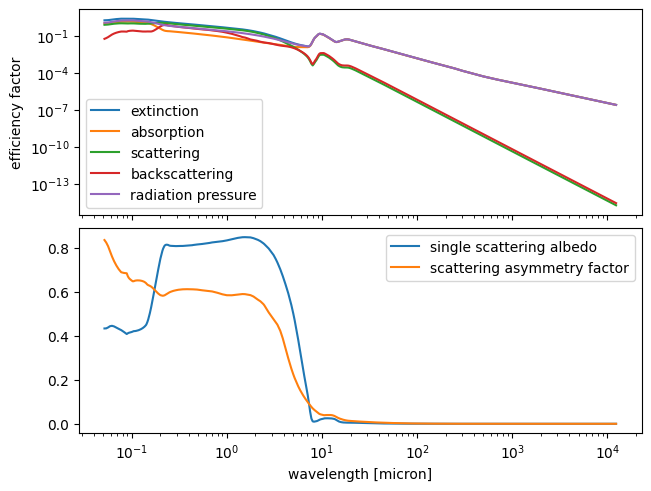

In [22]:
fig, ax = plt.subplots(2, 1, sharex=True, layout="constrained")

ax[0].plot(wavelength, q_ext, label="extinction")
ax[0].plot(wavelength, q_abs, label="absorption")
ax[0].plot(wavelength, q_sca, label="scattering")
ax[0].plot(wavelength, q_bk, label="backscattering")
ax[0].plot(wavelength, q_ext - g_sca * q_sca, label="radiation pressure")

ax[0].set_ylabel("efficiency factor")
ax[0].set_yscale("log")
ax[0].legend()

ax[1].plot(wavelength, albedo, label="single scattering albedo")
ax[1].plot(wavelength, g_sca, label="scattering asymmetry factor")

# ax[1].set_yscale("log")
ax[1].set_xlabel("wavelength [micron]")
ax[1].set_xscale("log")
ax[1].legend()

plt.show()

Plot the scattering matrix elements:

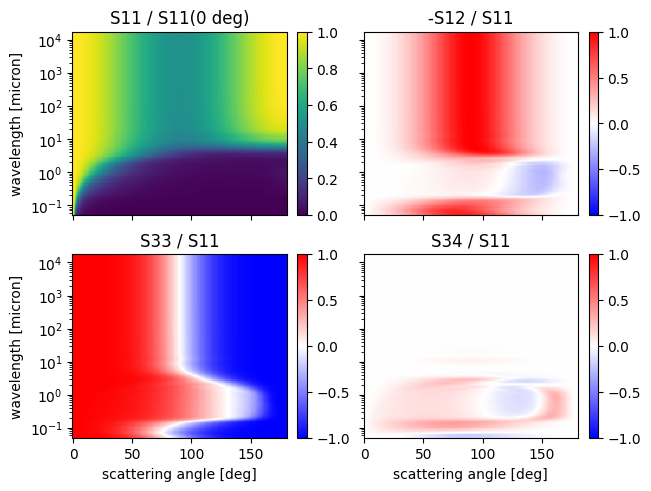

In [23]:
if doSA:
    if nlam == 1:
        fig, ax = plt.subplots(2, 2, sharex=True, layout="constrained")
        theta = np.linspace(0, 180, nang2)

        fig.suptitle(f"wavelength: {wavelength[0]} [micron]")

        ax[0,0].plot(theta, S11[:,0] / S11[0,0])
        ax[0,0].set_ylabel("S11")
        ax[0,0].set_yscale("log")

        ax[0,1].plot(theta, -S12[:,0] / S11[:,0])
        ax[0,1].set_ylabel("-S12 / S11")
        ax[0,1].yaxis.set_label_position("right")
        ax[0,1].yaxis.tick_right()

        ax[1,0].plot(theta, S33[:,0] / S11[:,0])
        ax[1,0].set_xlabel("scattering angle [deg]")
        ax[1,0].set_ylabel("S33 / S11")

        ax[1,1].plot(theta, S34[:,0] / S11[:,0])
        ax[1,1].set_xlabel("scattering angle [deg]")
        ax[1,1].set_ylabel("S34 / S11")
        ax[1,1].yaxis.set_label_position("right")
        ax[1,1].yaxis.tick_right()

    else:
        fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, layout="constrained")

        theta = np.linspace(0, 180, nang2)

        im = ax[0,0].pcolormesh(theta, wavelength, np.transpose(S11 / S11[0,:]), vmax=1, vmin=0, shading="nearest")
        ax[0,0].set_title("S11 / S11(0 deg)")
        ax[0,0].set_ylabel("wavelength [micron]")
        ax[0,0].set_yscale("log")
        fig.colorbar(im, ax=ax[0,0])

        im = ax[0,1].pcolormesh(theta, wavelength, np.transpose(-S12 / S11), vmin=-1, vmax=1, cmap="bwr")
        ax[0,1].set_title("-S12 / S11")
        fig.colorbar(im, ax=ax[0,1])

        im = ax[1,0].pcolormesh(theta, wavelength, np.transpose(S33 / S11), vmin=-1, vmax=1, cmap="bwr")
        ax[1,0].set_title("S33 / S11")
        ax[1,0].set_xlabel("scattering angle [deg]")
        ax[1,0].set_ylabel("wavelength [micron]")
        fig.colorbar(im, ax=ax[1,0])

        im = ax[1,1].pcolormesh(theta, wavelength, np.transpose(S34 / S11), vmin=-1, vmax=1, cmap="bwr")
        ax[1,1].set_title("S34 / S11")
        ax[1,1].set_xlabel("scattering angle [deg]")
        fig.colorbar(im, ax=ax[1,1])
    
    plt.show()